In [8]:
"""
ALTERNATIVE ENSEMBLE METHODS FOR SMALL MEDICAL DATASETS

Since Stacking didn't improve accuracy, we'll try simpler, more effective methods:
1. Voting Classifier (Hard & Soft Voting) - Simple majority voting
2. Weighted Voting - Weight models by their individual performance
3. Blending - Simple 2-level ensemble without complex meta-learner
4. Weighted Average of Probabilities - Combine predictions with performance-based weights

These methods are often MORE effective than stacking on small datasets because:
- Less prone to overfitting
- Simpler = more stable
- Direct combination of strong models
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Import LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM not available.")

# ==========================================
# STEP 1: DATA ENGINEERING
# ==========================================
def prepare_datasets():
    print("--- Step 1: Loading and Merging Data ---")
    try:
        df_cleaned = pd.read_csv('cleaned.csv')
        df_test = pd.read_csv('cleaned_test.csv')
        df_combined = pd.concat([df_cleaned, df_test], ignore_index=True)
        X = df_combined.drop(columns=['Disease'])
        y = df_combined['Disease']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Data merged. Total rows: {len(df_combined)}")
        print(f"Training set shape: {X_train.shape}")
        print(f"Test set shape: {X_test.shape}")
        return X_train, X_test, y_train, y_test
    except FileNotFoundError:
        print("Error: 'cleaned.csv' or 'cleaned_test.csv' not found.")
        return None, None, None, None

# ==========================================
# STEP 2: PREPROCESSING & SMOTE
# ==========================================
def preprocess_and_balance(X_train, y_train):
    print("\n--- Step 2: Preprocessing & Balancing ---")
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Disease Label Mapping:", label_mapping)

    try:
        from imblearn.over_sampling import SMOTE
        print("Applying SMOTE to handle class imbalance...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    except ImportError:
        print("Warning: 'imblearn' library not found. Using manual oversampling fallback.")
        train_data = pd.concat([X_train, pd.Series(y_train_encoded, name='Disease')], axis=1)
        max_size = train_data['Disease'].value_counts().max()
        lst = [train_data]
        for class_index, group in train_data.groupby('Disease'):
            lst.append(group.sample(max_size-len(group), replace=True, random_state=42))
        train_data_resampled = pd.concat(lst)
        X_train_resampled = train_data_resampled.drop('Disease', axis=1)
        y_train_resampled = train_data_resampled['Disease']

    print(f"Original training size: {len(X_train)}")
    print(f"Resampled training size: {len(X_train_resampled)}")
    return X_train_resampled, y_train_resampled, le


In [9]:
# ==========================================
# STEP 3: TRAIN BASE LEARNERS & GET WEIGHTS
# ==========================================
def train_and_weight_base_learners(X_train, y_train, X_test, y_test, le):
    """
    Train base learners and calculate their individual performance for weighting
    """
    print("\n" + "="*80)
    print("STEP 3: TRAINING BASE LEARNERS & CALCULATING WEIGHTS")
    print("="*80)
    
    y_test_encoded = le.transform(y_test)
    base_learners = {}
    base_performances = {}
    
    # 1. Gradient Boosting (optimized)
    print("\n1. Training Gradient Boosting...")
    gb_model = GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.08, max_depth=4,
        min_samples_split=3, min_samples_leaf=2, subsample=0.85, random_state=42
    )
    gb_model.fit(X_train, y_train)
    gb_pred = gb_model.predict(X_test)
    gb_acc = accuracy_score(y_test_encoded, gb_pred)
    gb_f1 = f1_score(y_test_encoded, gb_pred, average='weighted', zero_division=0)
    base_learners['gb'] = gb_model
    base_performances['gb'] = {'accuracy': gb_acc, 'f1': gb_f1}
    print(f"   ✓ Gradient Boosting - Accuracy: {gb_acc:.4f}, F1: {gb_f1:.4f}")
    
    # 2. LightGBM (optimized)
    if LIGHTGBM_AVAILABLE:
        print("\n2. Training LightGBM...")
        lgb_model = lgb.LGBMClassifier(
            n_estimators=150, learning_rate=0.08, max_depth=4,
            num_leaves=15, min_child_samples=3, subsample=0.85,
            colsample_bytree=0.85, random_state=42, verbose=-1, n_jobs=-1
        )
        lgb_model.fit(X_train, y_train)
        lgb_pred = lgb_model.predict(X_test)
        lgb_acc = accuracy_score(y_test_encoded, lgb_pred)
        lgb_f1 = f1_score(y_test_encoded, lgb_pred, average='weighted', zero_division=0)
        base_learners['lgb'] = lgb_model
        base_performances['lgb'] = {'accuracy': lgb_acc, 'f1': lgb_f1}
        print(f"   ✓ LightGBM - Accuracy: {lgb_acc:.4f}, F1: {lgb_f1:.4f}")
    
    # 3. Random Forest (optimized)
    print("\n3. Training Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=200, max_depth=8, min_samples_split=3,
        min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test_encoded, rf_pred)
    rf_f1 = f1_score(y_test_encoded, rf_pred, average='weighted', zero_division=0)
    base_learners['rf'] = rf_model
    base_performances['rf'] = {'accuracy': rf_acc, 'f1': rf_f1}
    print(f"   ✓ Random Forest - Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}")
    
    # Calculate weights based on F1-score (normalized)
    total_f1 = sum(perf['f1'] for perf in base_performances.values())
    weights = {name: perf['f1'] / total_f1 for name, perf in base_performances.items()}
    
    print("\n" + "="*80)
    print("BASE LEARNER WEIGHTS (Based on F1-Score)")
    print("="*80)
    for name, weight in weights.items():
        print(f"{name:20s}: {weight:.4f} ({weight*100:.2f}%)")
    print("="*80)
    
    return base_learners, base_performances, weights


In [10]:
# ==========================================
# STEP 4: METHOD 1 - VOTING CLASSIFIER (HARD & SOFT)
# ==========================================
def create_voting_ensembles(base_learners):
    """
    Create both Hard Voting and Soft Voting classifiers
    """
    print("\n" + "="*80)
    print("METHOD 1: VOTING CLASSIFIER")
    print("="*80)
    
    estimators = []
    if 'gb' in base_learners:
        estimators.append(('gb', GradientBoostingClassifier(
            n_estimators=150, learning_rate=0.08, max_depth=4,
            min_samples_split=3, min_samples_leaf=2, subsample=0.85, random_state=42
        )))
    if 'lgb' in base_learners and LIGHTGBM_AVAILABLE:
        estimators.append(('lgb', lgb.LGBMClassifier(
            n_estimators=150, learning_rate=0.08, max_depth=4,
            num_leaves=15, min_child_samples=3, subsample=0.85,
            colsample_bytree=0.85, random_state=42, verbose=-1, n_jobs=-1
        )))
    if 'rf' in base_learners:
        estimators.append(('rf', RandomForestClassifier(
            n_estimators=200, max_depth=8, min_samples_split=3,
            min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1
        )))
    
    # Hard Voting (majority vote)
    hard_voting = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)
    
    # Soft Voting (average probabilities)
    soft_voting = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
    
    print(f"Created Voting Classifiers with {len(estimators)} base learners")
    print("  - Hard Voting: Majority class wins")
    print("  - Soft Voting: Average probabilities")
    
    return hard_voting, soft_voting, estimators


In [11]:
# ==========================================
# STEP 5: METHOD 2 - WEIGHTED AVERAGE OF PROBABILITIES
# ==========================================
def weighted_average_predictions(base_learners, weights, X_test, le):
    """
    Combine predictions using weighted average of probabilities
    """
    print("\n" + "="*80)
    print("METHOD 2: WEIGHTED AVERAGE OF PROBABILITIES")
    print("="*80)
    
    # Get probability predictions from all base learners
    all_probas = []
    for name, model in base_learners.items():
        proba = model.predict_proba(X_test)
        weighted_proba = proba * weights[name]
        all_probas.append(weighted_proba)
        print(f"  {name}: Weight = {weights[name]:.4f}")
    
    # Average the weighted probabilities
    avg_proba = np.sum(all_probas, axis=0)
    
    # Get predictions
    predictions = np.argmax(avg_proba, axis=1)
    
    return predictions, avg_proba


In [12]:
# ==========================================
# STEP 6: METHOD 3 - BLENDING (SIMPLE 2-LEVEL)
# ==========================================
def create_blending_ensemble(base_learners, X_train, y_train, X_test, le):
    """
    Simple blending: Train base learners, get predictions, train simple meta-learner
    """
    print("\n" + "="*80)
    print("METHOD 3: BLENDING (SIMPLE 2-LEVEL ENSEMBLE)")
    print("="*80)
    
    # Split training data for blending
    from sklearn.model_selection import train_test_split
    X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(
        X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
    )
    
    # Train base learners on first part
    print("Training base learners on 70% of training data...")
    base_predictions_meta = []
    for name, model in base_learners.items():
        model.fit(X_train_base, y_train_base)
        # Get probability predictions for meta-training
        proba = model.predict_proba(X_train_meta)
        base_predictions_meta.append(proba)
        print(f"  ✓ {name} trained")
    
    # Stack predictions horizontally
    meta_features = np.hstack(base_predictions_meta)
    
    # Train simple meta-learner (Logistic Regression with regularization)
    print("Training meta-learner (Logistic Regression)...")
    meta_learner = LogisticRegression(
        max_iter=2000, C=0.1, random_state=42, n_jobs=-1,
        multi_class='multinomial', solver='lbfgs'
    )
    meta_learner.fit(meta_features, y_train_meta)
    print("  ✓ Meta-learner trained")
    
    # Get predictions on test set
    test_predictions = []
    for name, model in base_learners.items():
        proba = model.predict_proba(X_test)
        test_predictions.append(proba)
    
    test_meta_features = np.hstack(test_predictions)
    blending_predictions = meta_learner.predict(test_meta_features)
    
    return blending_predictions, meta_learner


In [13]:
# ==========================================
# STEP 7: EVALUATE ALL METHODS
# ==========================================
def evaluate_all_methods(X_train, y_train, X_test, y_test, le, base_learners, 
                         base_performances, weights, hard_voting, soft_voting):
    """
    Train and evaluate all ensemble methods
    """
    print("\n" + "="*80)
    print("STEP 7: EVALUATING ALL ENSEMBLE METHODS")
    print("="*80)
    
    y_test_encoded = le.transform(y_test)
    results = []
    
    # 1. Individual Base Learners
    print("\n1. Evaluating Individual Base Learners...")
    for name, model in base_learners.items():
        pred = model.predict(X_test)
        acc = accuracy_score(y_test_encoded, pred)
        f1 = f1_score(y_test_encoded, pred, average='weighted', zero_division=0)
        prec = precision_score(y_test_encoded, pred, average='weighted', zero_division=0)
        rec = recall_score(y_test_encoded, pred, average='weighted', zero_division=0)
        results.append({
            'Method': name.upper(),
            'Type': 'Base Learner',
            'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1
        })
        print(f"   {name:20s}: Acc={acc:.4f}, F1={f1:.4f}")
    
    # 2. Hard Voting
    print("\n2. Training & Evaluating Hard Voting...")
    hard_voting.fit(X_train, y_train)
    hard_pred = hard_voting.predict(X_test)
    hard_acc = accuracy_score(y_test_encoded, hard_pred)
    hard_f1 = f1_score(y_test_encoded, hard_pred, average='weighted', zero_division=0)
    hard_prec = precision_score(y_test_encoded, hard_pred, average='weighted', zero_division=0)
    hard_rec = recall_score(y_test_encoded, hard_pred, average='weighted', zero_division=0)
    results.append({
        'Method': 'Hard Voting',
        'Type': 'Ensemble',
        'Accuracy': hard_acc, 'Precision': hard_prec, 'Recall': hard_rec, 'F1-Score': hard_f1
    })
    print(f"   Hard Voting: Acc={hard_acc:.4f}, F1={hard_f1:.4f}")
    
    # 3. Soft Voting
    print("\n3. Training & Evaluating Soft Voting...")
    soft_voting.fit(X_train, y_train)
    soft_pred = soft_voting.predict(X_test)
    soft_acc = accuracy_score(y_test_encoded, soft_pred)
    soft_f1 = f1_score(y_test_encoded, soft_pred, average='weighted', zero_division=0)
    soft_prec = precision_score(y_test_encoded, soft_pred, average='weighted', zero_division=0)
    soft_rec = recall_score(y_test_encoded, soft_pred, average='weighted', zero_division=0)
    results.append({
        'Method': 'Soft Voting',
        'Type': 'Ensemble',
        'Accuracy': soft_acc, 'Precision': soft_prec, 'Recall': soft_rec, 'F1-Score': soft_f1
    })
    print(f"   Soft Voting: Acc={soft_acc:.4f}, F1={soft_f1:.4f}")
    
    # 4. Weighted Average
    print("\n4. Evaluating Weighted Average...")
    weighted_pred, _ = weighted_average_predictions(base_learners, weights, X_test, le)
    weighted_acc = accuracy_score(y_test_encoded, weighted_pred)
    weighted_f1 = f1_score(y_test_encoded, weighted_pred, average='weighted', zero_division=0)
    weighted_prec = precision_score(y_test_encoded, weighted_pred, average='weighted', zero_division=0)
    weighted_rec = recall_score(y_test_encoded, weighted_pred, average='weighted', zero_division=0)
    results.append({
        'Method': 'Weighted Avg',
        'Type': 'Ensemble',
        'Accuracy': weighted_acc, 'Precision': weighted_prec, 'Recall': weighted_rec, 'F1-Score': weighted_f1
    })
    print(f"   Weighted Average: Acc={weighted_acc:.4f}, F1={weighted_f1:.4f}")
    
    # 5. Blending
    print("\n5. Training & Evaluating Blending...")
    blending_pred, meta_learner = create_blending_ensemble(base_learners, X_train, y_train, X_test, le)
    blending_acc = accuracy_score(y_test_encoded, blending_pred)
    blending_f1 = f1_score(y_test_encoded, blending_pred, average='weighted', zero_division=0)
    blending_prec = precision_score(y_test_encoded, blending_pred, average='weighted', zero_division=0)
    blending_rec = recall_score(y_test_encoded, blending_pred, average='weighted', zero_division=0)
    results.append({
        'Method': 'Blending',
        'Type': 'Ensemble',
        'Accuracy': blending_acc, 'Precision': blending_prec, 'Recall': blending_rec, 'F1-Score': blending_f1
    })
    print(f"   Blending: Acc={blending_acc:.4f}, F1={blending_f1:.4f}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('F1-Score', ascending=False)
    
    print("\n" + "="*80)
    print("ALL METHODS COMPARISON (Sorted by F1-Score)")
    print("="*80)
    print(results_df.to_string(index=False))
    print("="*80)
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Accuracy
    ax1 = axes[0, 0]
    colors = ['skyblue' if t == 'Base Learner' else 'gold' for t in results_df['Type']]
    bars = ax1.barh(results_df['Method'], results_df['Accuracy'], color=colors)
    ax1.set_xlabel('Accuracy', fontweight='bold')
    ax1.set_title('Accuracy Comparison', fontweight='bold')
    ax1.set_xlim([0.85, 1.0])
    for i, (bar, v) in enumerate(zip(bars, results_df['Accuracy'])):
        ax1.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')
    
    # Plot 2: F1-Score
    ax2 = axes[0, 1]
    bars = ax2.barh(results_df['Method'], results_df['F1-Score'], color=colors)
    ax2.set_xlabel('F1-Score', fontweight='bold')
    ax2.set_title('F1-Score Comparison', fontweight='bold')
    ax2.set_xlim([0.85, 1.0])
    for i, (bar, v) in enumerate(zip(bars, results_df['F1-Score'])):
        ax2.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')
    
    # Plot 3: All Metrics
    ax3 = axes[1, 0]
    x = np.arange(len(results_df))
    width = 0.2
    ax3.bar(x - 1.5*width, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
    ax3.bar(x - 0.5*width, results_df['Precision'], width, label='Precision', color='lightgreen')
    ax3.bar(x + 0.5*width, results_df['Recall'], width, label='Recall', color='coral')
    ax3.bar(x + 1.5*width, results_df['F1-Score'], width, label='F1-Score', color='gold')
    ax3.set_xlabel('Methods')
    ax3.set_ylabel('Score')
    ax3.set_title('All Metrics Comparison', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(results_df['Method'], rotation=45, ha='right')
    ax3.legend()
    ax3.set_ylim([0.85, 1.0])
    
    # Plot 4: Improvement over best base learner
    ax4 = axes[1, 1]
    best_base_f1 = results_df[results_df['Type'] == 'Base Learner']['F1-Score'].max()
    improvements = []
    method_names = []
    for _, row in results_df.iterrows():
        if row['Type'] == 'Ensemble':
            improvement = ((row['F1-Score'] - best_base_f1) / best_base_f1) * 100
            improvements.append(improvement)
            method_names.append(row['Method'])
    
    if improvements:
        colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
        bars = ax4.barh(method_names, improvements, color=colors_imp)
        ax4.set_xlabel('Improvement (%)', fontweight='bold')
        ax4.set_title('Improvement over Best Base Learner', fontweight='bold')
        ax4.axvline(0, color='black', linestyle='--', linewidth=1)
        for i, (bar, v) in enumerate(zip(bars, improvements)):
            ax4.text(v + 0.1 if v > 0 else v - 0.3, i, f'{v:+.2f}%', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('alternative_ensembles_comparison.png', dpi=300, bbox_inches='tight')
    print("\nComparison chart saved as 'alternative_ensembles_comparison.png'")
    
    # Best method
    best_method = results_df.iloc[0]
    print("\n" + "="*80)
    print(f"BEST METHOD: {best_method['Method']}")
    print("="*80)
    print(f"Accuracy: {best_method['Accuracy']:.4f}")
    print(f"F1-Score: {best_method['F1-Score']:.4f}")
    print(f"Precision: {best_method['Precision']:.4f}")
    print(f"Recall: {best_method['Recall']:.4f}")
    print("="*80)
    
    return results_df, best_method


--- Step 1: Loading and Merging Data ---
Data merged. Total rows: 551
Training set shape: (440, 24)
Test set shape: (111, 24)

--- Step 2: Preprocessing & Balancing ---
Disease Label Mapping: {'Anemia': np.int64(0), 'Diabetes': np.int64(1), 'Healthy': np.int64(2), 'Heart Di': np.int64(3), 'Thalasse': np.int64(4), 'Thromboc': np.int64(5)}
Applying SMOTE to handle class imbalance...
Original training size: 440
Resampled training size: 1488

STEP 3: TRAINING BASE LEARNERS & CALCULATING WEIGHTS

1. Training Gradient Boosting...
   ✓ Gradient Boosting - Accuracy: 0.8919, F1: 0.8897

2. Training LightGBM...
   ✓ LightGBM - Accuracy: 0.9099, F1: 0.9042

3. Training Random Forest...
   ✓ Random Forest - Accuracy: 0.9099, F1: 0.9076

BASE LEARNER WEIGHTS (Based on F1-Score)
gb                  : 0.3293 (32.93%)
lgb                 : 0.3347 (33.47%)
rf                  : 0.3360 (33.60%)

METHOD 1: VOTING CLASSIFIER
Created Voting Classifiers with 3 base learners
  - Hard Voting: Majority class w

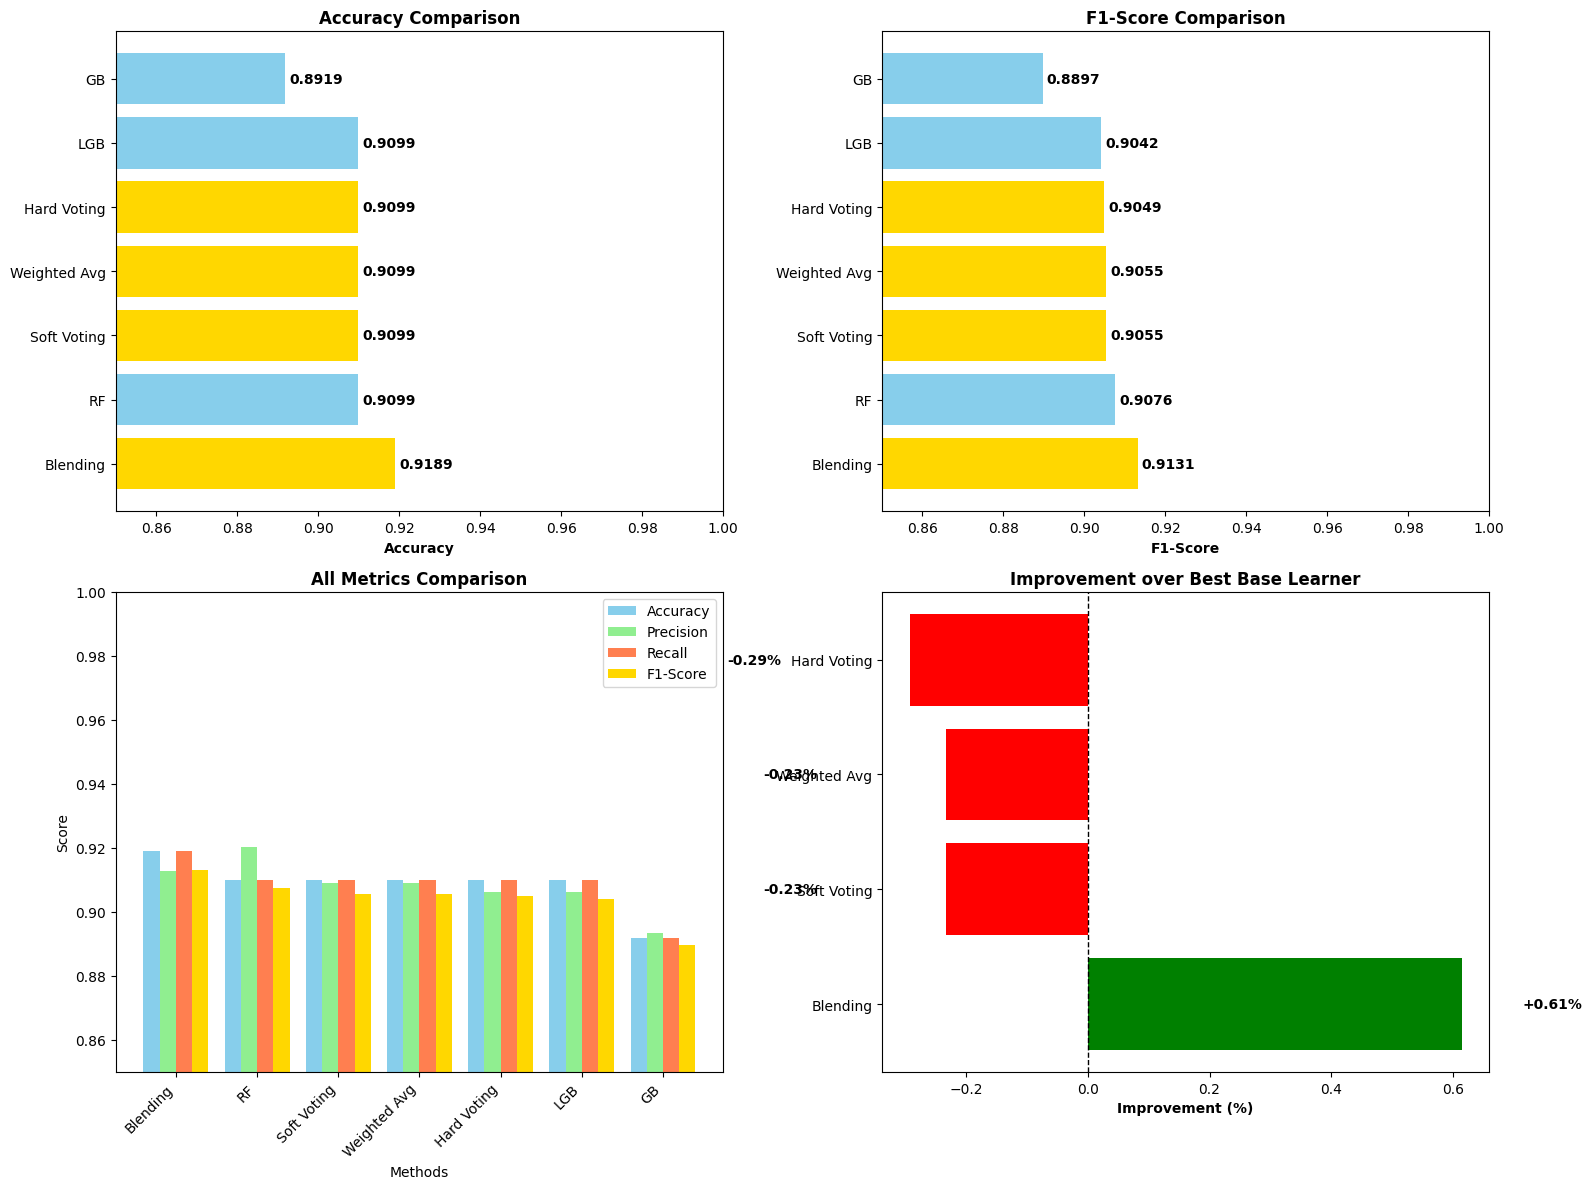

In [14]:
# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Prepare Data
    X_train, X_test, y_train, y_test = prepare_datasets()
    
    if X_train is not None:
        # 2. Balance Data
        X_train_resampled, y_train_resampled, label_encoder = preprocess_and_balance(X_train, y_train)
        
        # 3. Train Base Learners & Calculate Weights
        base_learners, base_performances, weights = train_and_weight_base_learners(
            X_train_resampled, y_train_resampled, X_test, y_test, label_encoder
        )
        
        # 4. Create Voting Classifiers
        hard_voting, soft_voting, estimators = create_voting_ensembles(base_learners)
        
        # 5. Evaluate All Methods
        results_df, best_method = evaluate_all_methods(
            X_train_resampled, y_train_resampled, X_test, y_test, label_encoder,
            base_learners, base_performances, weights, hard_voting, soft_voting
        )
        
        # 6. Save Best Model
        print("\n" + "="*80)
        print("SAVING BEST MODEL")
        print("="*80)
        
        best_method_name = best_method['Method']
        
        if best_method_name == 'Hard Voting':
            joblib.dump(hard_voting, 'best_ensemble_model.pkl')
        elif best_method_name == 'Soft Voting':
            joblib.dump(soft_voting, 'best_ensemble_model.pkl')
        elif best_method_name == 'Weighted Avg':
            # Save base learners and weights for weighted average
            joblib.dump({'models': base_learners, 'weights': weights}, 'best_ensemble_model.pkl')
        elif best_method_name == 'Blending':
            # Recreate blending model
            _, meta_learner = create_blending_ensemble(base_learners, X_train_resampled, 
                                                       y_train_resampled, X_test, label_encoder)
            joblib.dump({'base_learners': base_learners, 'meta_learner': meta_learner}, 
                       'best_ensemble_model.pkl')
        else:
            # Best is a base learner
            joblib.dump(base_learners[best_method_name.lower()], 'best_ensemble_model.pkl')
        
        joblib.dump(label_encoder, 'label_encoder.pkl')
        results_df.to_csv('alternative_ensembles_results.csv', index=False)
        
        print(f"✓ Best model ({best_method_name}) saved as 'best_ensemble_model.pkl'")
        print("✓ Label encoder saved as 'label_encoder.pkl'")
        print("✓ Results saved as 'alternative_ensembles_results.csv'")
        print("="*80)
